In [206]:
import numpy as np
import matplotlib.pyplot as plt

In [207]:
data_train = np.load('./data/panda/train_data.npz')
data_test  = np.load('./data/panda/test_data.npz')
x_train, y_train = data_train['x'], data_train['y']
x_test, y_test  = data_test['x'],  data_test['y']
print(f'train shape-> x:{x_train.shape}, y:{y_train.shape}')
print(f'test  shape-> x:{x_test.shape}, y:{y_test.shape}')

train shape-> x:(2000, 12288), y:(2000,)
test  shape-> x:(400, 12288), y:(400,)


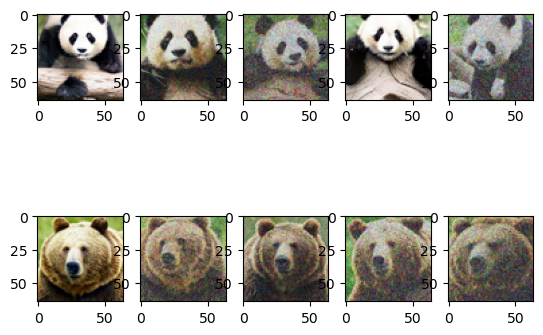

In [208]:
fig, ax = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        index = np.where(y_train == i)[0][j]
        ax[i, j].imshow(x_train.reshape(-1, 64, 64, 3)[index])
plt.show()

In [209]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
import torch.nn.functional as F

In [210]:
class POBDataSet(Dataset):
    def __init__(self, x, y) -> None:
        self.x = torch.from_numpy(x)/255.
        self.y = torch.from_numpy(y).long()
    
    def __getitem__(self, index):
        return self.x[index].float(), self.y[index]
    
    def __len__(self):
        return self.x.shape[0]

train_dataset = POBDataSet(x_train, y_train)
test_dataset  = POBDataSet(x_test, y_test)

train_dataloader = DataLoader(train_dataset, 512, True)
test_dataloader  = DataLoader(test_dataset, 512, False)

In [211]:
example = iter(train_dataloader)
sample, label = example._next_data()
print(sample.shape)
print(label.shape)

torch.Size([512, 12288])
torch.Size([512])


In [212]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(12288, 3)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(3, 3)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(3, 2)
        # self.relu3 = nn.ReLU()
        # self.fc4 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        # x = self.relu3(x)
        # x = self.fc4(x)
        return x

    
model = Model()
criterion = nn.CrossEntropyLoss()
optim = SGD(model.parameters(), lr=0.02)

In [213]:
epochs = 10
total_step = len(train_dataloader)
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_dataloader):
        optim.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optim.step()

        # if i%256 == 0:
        #     print(f'{epoch}/{epochs}, {i}/{total_step}, loss:{loss.item():.4f}')
    print(f'{epoch}/{epochs}, loss:{loss.item():.4f}')

0/10, loss:0.6544
1/10, loss:0.6025
2/10, loss:0.5558
3/10, loss:0.5511
4/10, loss:0.4583
5/10, loss:0.4704
6/10, loss:0.4759
7/10, loss:0.4055
8/10, loss:0.3706
9/10, loss:0.3568


In [214]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for x, y in test_dataloader:
        output = model(x)
        _, prediction = torch.max(output, 1)
        n_correct += (prediction == y).sum().item()
        n_samples += y.size(0)
    print(100*n_correct/n_samples)


92.25
